In [1]:
import numpy as np, matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
from astropy import wcs
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.modeling import models, fitting
from scipy.interpolate import RectBivariateSpline as rbs
from dsacalib.preprocess import read_nvss_catalog
import pandas as pd
pd.options.mode.chained_assignment = None
df = read_nvss_catalog()
ras = df.loc[:,'ra']; decs = df.loc[:,'dec']
coords = SkyCoord(ras,decs,frame='icrs',unit='deg')
maj = df.loc[:,'major_axis']; flux = df.loc[:,'flux_20_cm']

In [2]:
# wsclean -weight briggs 0.5 -name fimg_bp -size 6000 6000 -scale 2asec -minuv-l 500 -niter 2000 -auto-threshold 5.0 -theoretic-beam -data-column DATA field.ms/
# wsclean -weight briggs 0.5 -name fimg_bp -size 3500 3500 -scale 4asec -minuv-l 300 -niter 10 -auto-threshold 5.0 -theoretic-beam frb_bp.ms

d = fits.open('/dataz/dsa110/candidates/221203aaaa/Level2/calibration/fimg-image.fits')
image = d[0].data[0,0,:,:]
w = WCS(d[0].header)
skypos = w.wcs_pix2world(image.shape[0]/2, image.shape[0]/2, 0, 0, 0)
pos = SkyCoord([skypos[0]],[skypos[1]],unit=(u.deg,u.deg))


In [3]:
# NVSS conditions
flux_lt = 50.0
maj_lt = 30.0
rad_lt = 2.5

idx, d2d, d3d = coords.match_to_catalog_sky(pos)
wrs = np.where((flux>flux_lt) & (maj<maj_lt) & (d2d.deg<rad_lt))[0]
ccoords = coords[wrs]
fflux = flux[wrs]
mmaj = maj[wrs]

world_coords = np.zeros((len(ccoords),4))
world_coords[:,0] = ccoords.ra.value
world_coords[:,1] = ccoords.dec.value
world_coords[:,3] = 1.
world_coords[:,2] = 1.405e9
pix_coords = w.wcs_world2pix(world_coords,0)
rapix = np.floor(pix_coords[:,0]).astype('int')
depix = np.floor(pix_coords[:,1]).astype('int')

In [4]:
def fit_src(ira,idec,plot=True,nside=100,method='gaus'):
    
    
    nont = int(nside/2)
    mydata = image[idec-nont:idec+nont,ira-nont:ira+nont]
    
    if idec-nont<0:
        return None
    if idec+nont>=image.shape[0]:
        return None
    if ira-nont<0:
        return None
    if ira+nont>=image.shape[0]:
        return None
    
    if not mydata[nont,nont] > 0.:
        return None
    
    
    if method=='gaus':
    
        gaus = models.Gaussian2D(amplitude=0.03,
                                 x_mean=0.,
                                 y_mean=0.,
                                 x_stddev=3.0,
                                 y_stddev=3.0,
                                 theta=np.pi/2.)
    
        y, x = np.mgrid[:nside, :nside]
        y = y.astype(np.float64)
        x = x.astype(np.float64)
        y -= nside/2.+0.5
        x -= nside/2.+0.5
        fit = fitting.LevMarLSQFitter()
        p = fit(gaus, x, y, mydata)
    
        print(p.amplitude.value,p.x_mean.value,p.y_mean.value)
    
        if plot:
            plt.figure(figsize=(10,5))
        
            plt.subplot(1,2,1)
            plt.imshow(mydata,vmin=-0.001,vmax=0.05,origin='lower')
            plt.title('Data')
        
            plt.subplot(1,2,2)
            plt.imshow(mydata-p(x,y),vmin=-0.001,vmax=0.05,origin='lower')
            plt.title('Residual')
        
            plt.show()
        
        return p.amplitude.value,p.y_mean.value,p.x_mean.value
    
    if method=='interp':
        
        x = np.arange(nside)-(nside/2.+0.5)
        y = np.arange(nside)-(nside/2.+0.5)
        p = rbs(x,y,mydata)
        
        manyx = np.linspace(np.min(x),np.max(x),nside*20)
        manyy = np.linspace(np.min(y),np.max(y),nside*20)
        
        interps = p(manyx,manyy)
        wrs = np.where(interps==np.max(interps))
        
        x_mean = manyx[wrs[0]]
        y_mean = manyy[wrs[1]]
        amp = np.max(interps)
        
        print(amp,x_mean,y_mean)
        
        if plot:
            plt.figure(figsize=(5,5))
        
            plt.imshow(mydata,origin='lower',vmin=-0.001,vmax=0.05,extent=[np.min(x),np.max(x),np.min(y),np.max(y)])
            plt.plot([y_mean],[x_mean],'kx')
            plt.title('Data')
        
            plt.show()
            
        return(amp,x_mean,y_mean)
        
        
        

Flux (mJy): 170.7
Flux (mJy): 157.3
Flux (mJy): 67.9
Flux (mJy): 148.5
Flux (mJy): 308.1
Flux (mJy): 222.1
Flux (mJy): 303.5
Flux (mJy): 101.9
Flux (mJy): 68.8
0.033693634521696235 [-0.09699625] [-2.14705882]


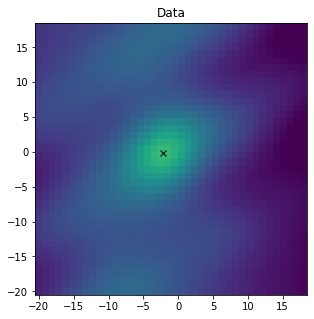

Flux (mJy): 252.3
0.08991905308391616 [0.63516896] [-0.34105131]


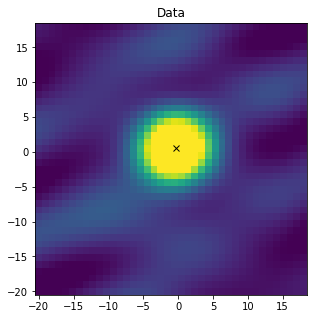

Flux (mJy): 62.6
0.03215313920743884 [-0.24342929] [-0.48748436]


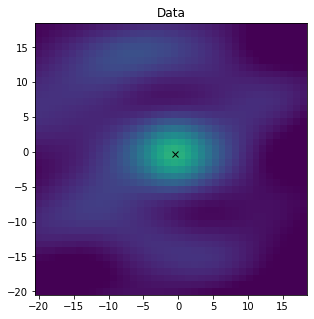

Flux (mJy): 252.6
0.07349289670174268 [0.53754693] [0.63516896]


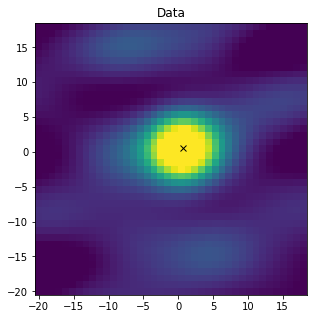

Flux (mJy): 77.7
0.027088440325397048 [-1.3660826] [-1.51251564]


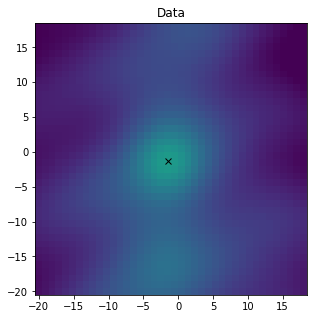

Flux (mJy): 82.9
0.021588124904511726 [11.12953692] [0.43992491]


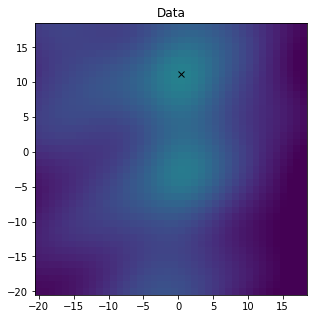

Flux (mJy): 399.9
Flux (mJy): 62.3
0.039323094306522706 [0.19586984] [-0.2922403]


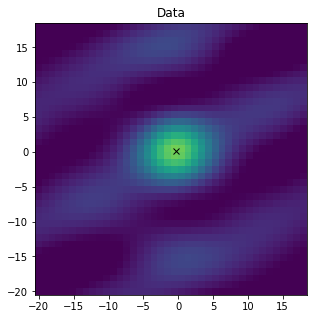

Flux (mJy): 56.0
0.027797029117785945 [0.14705882] [-0.73153942]


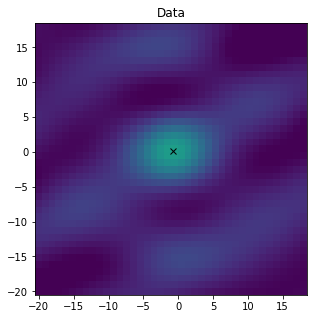

Flux (mJy): 55.0
0.023366207958780937 [0.24468085] [-0.48748436]


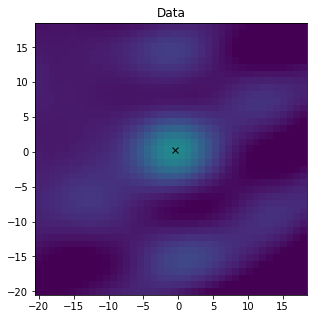

Flux (mJy): 65.7
0.030084756875380914 [3.41739675] [3.2709637]


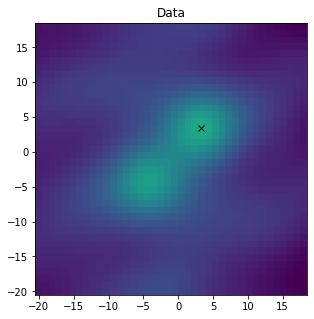

Flux (mJy): 73.2
Flux (mJy): 52.0
0.04510092835398744 [-0.2922403] [-0.2922403]


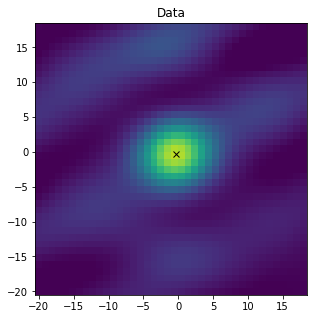

Flux (mJy): 85.8
0.060439407319291386 [-0.14580726] [-0.43867334]


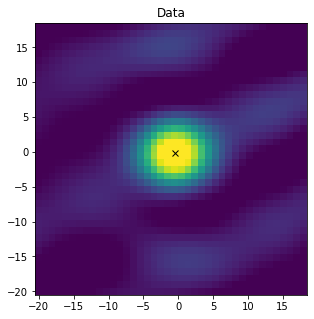

Flux (mJy): 171.1
Flux (mJy): 58.3
0.030507442120319205 [0.00062578] [-0.48748436]


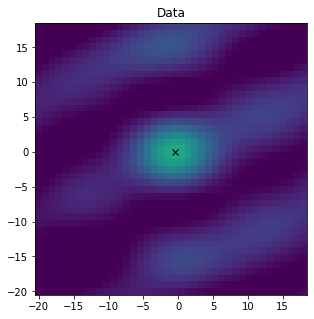

Flux (mJy): 94.8
0.05825077699855637 [0.34230288] [0.73279099]


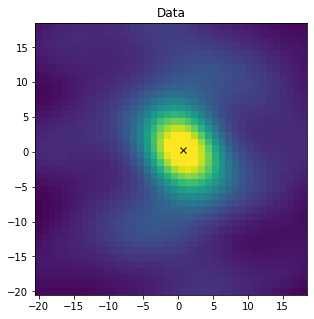

Flux (mJy): 74.1
0.06535054367164371 [0.24468085] [-0.2922403]


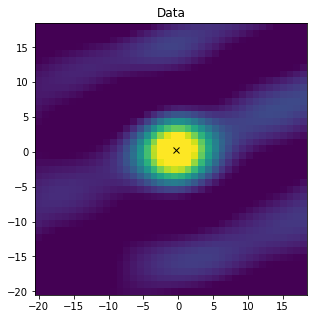

Flux (mJy): 55.4
0.04398004427559037 [0.73279099] [-0.19461827]


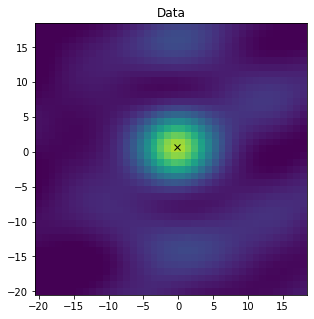

Flux (mJy): 80.3
Flux (mJy): 156.0
0.07867269531412699 [-1.12202753] [0.39111389]


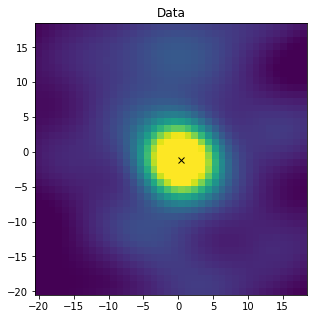

Flux (mJy): 70.2
0.05225099712181289 [0.19586984] [0.19586984]


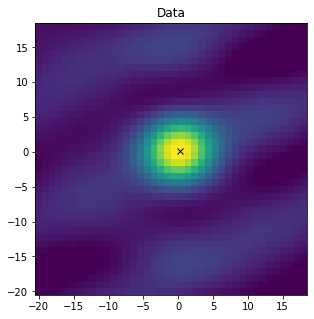

Flux (mJy): 115.5
Flux (mJy): 92.2
Flux (mJy): 99.5
Flux (mJy): 57.1
0.019552581584618724 [1.17209011] [-3.4649562]


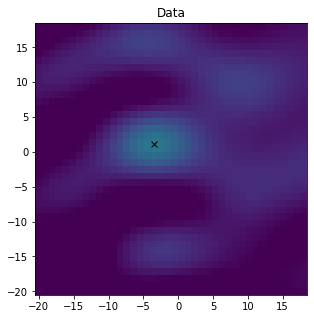

Flux (mJy): 79.6
Flux (mJy): 64.2
0.053917250010431496 [-0.38986233] [0.43992491]


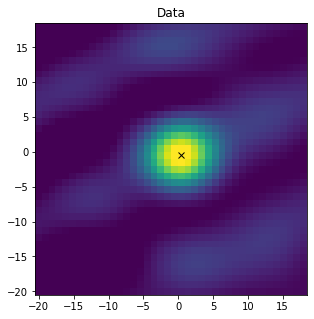

Flux (mJy): 65.6
Flux (mJy): 69.7
0.04480137622442925 [0.24468085] [-0.48748436]


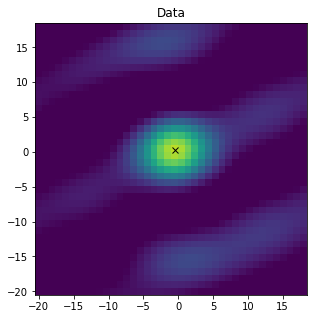

Flux (mJy): 92.8
0.10568249323504063 [-0.19461827] [-0.48748436]


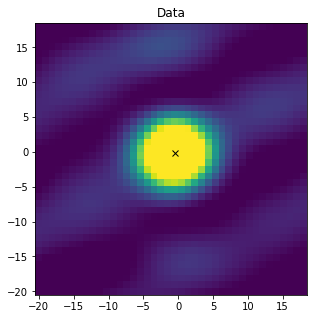

Flux (mJy): 108.7
0.07741188985270687 [-0.82916145] [-1.31727159]


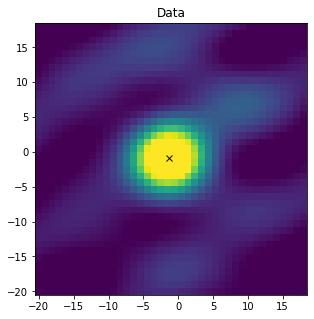

Flux (mJy): 818.8
Flux (mJy): 76.5
0.061078692521909464 [-0.09699625] [0.39111389]


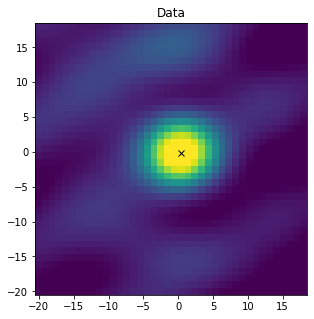

Flux (mJy): 86.1
0.04106587721979265 [-3.66020025] [1.31852315]


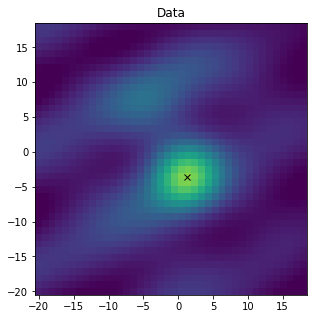

Flux (mJy): 76.2
Flux (mJy): 167.1
Flux (mJy): 63.4
0.031514885899899134 [-0.09699625] [-1.21964956]


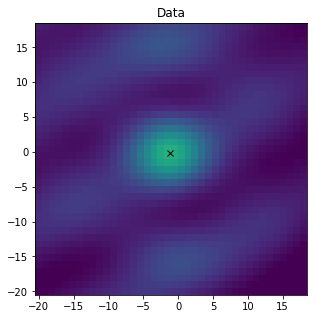

Flux (mJy): 84.3
Flux (mJy): 79.3
Flux (mJy): 526.5
0.36712532123415653 [-0.78035044] [-0.2922403]


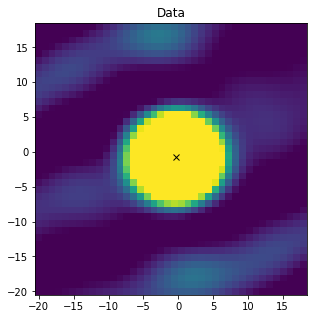

Flux (mJy): 85.6
0.06014706029198995 [-0.24342929] [-0.34105131]


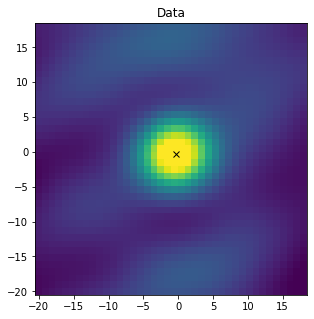

Flux (mJy): 403.7
Flux (mJy): 102.9
0.0603679593740057 [0.19586984] [-0.38986233]


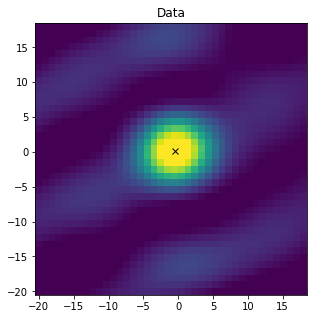

Flux (mJy): 54.8
0.03184809558083364 [0.48873592] [0.39111389]


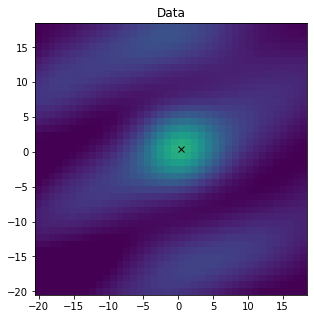

Flux (mJy): 52.0
0.03080792780085936 [-0.78035044] [0.97684606]


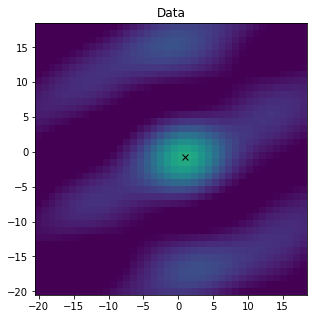

Flux (mJy): 56.3
Flux (mJy): 369.1
Flux (mJy): 86.0
Flux (mJy): 556.8
Flux (mJy): 76.6
Flux (mJy): 81.6
Flux (mJy): 85.5
Flux (mJy): 57.4


In [5]:
fit_amp = np.zeros(len(rapix))
fit_ra = np.zeros(len(rapix))
fit_dec = np.zeros(len(rapix))

for i in np.arange(len(rapix)):
    
    print('Flux (mJy):',fflux[i])
    
    pp = fit_src(rapix[i],depix[i],nside=40,method='interp')
    
    if pp is not None:
        famp,fx,fy = pp
        fit_amp[i] = famp
        fit_ra[i] = fy
        fit_dec[i] = fx



-0.6821026282853566 1.2703379224030016 252.3
1.2703379224030016 1.075093867334168 252.6
-0.8773466833541903 -0.29161451814768213 85.8
1.4655819774718424 0.6846057571964934 94.8
-0.5844806007509362 0.4893617021276597 74.1
0.7822277847309138 -2.2440550688360474 156.0
0.39173967459323933 0.39173967459323933 70.2
0.8798498122653342 -0.779724655819777 64.2
-0.9749687108886107 -0.38923654568210253 92.8
-2.634543178973715 -1.6583229036295393 108.7
0.7822277847309138 -0.19399249061326884 76.5
-0.5844806007509362 -1.5607008760951189 526.5
-0.6821026282853566 -0.4868585732165229 85.6
-0.779724655819777 0.39173967459323933 102.9
-0.15912748077954525 -0.23583050241373268
1.083690655127533 1.0123108289854044


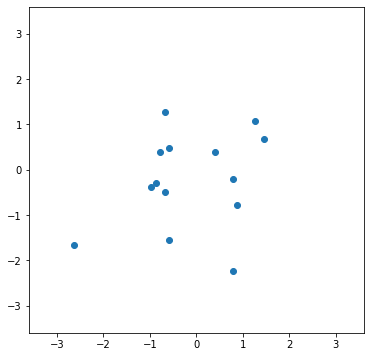

In [7]:
plt.figure(figsize=(6,6))
scl = 2.
fx = scl*fit_ra[fit_amp>0.05]
fy = scl*fit_dec[fit_amp>0.05]
fflux2 = fflux[fit_amp>0.05]
pixlt = 1.8*scl

mn1 = np.mean(fx[np.abs(fx)<pixlt]); mn2 = np.mean(fy[np.abs(fy)<pixlt])
#fx -= mn1; fy -= mn2

plt.scatter(fx,fy)


for i in np.arange(len(fx)):
    print(fx[i],fy[i],fflux2[i])

plt.xlim(-pixlt,pixlt)
plt.ylim(-pixlt,pixlt)
print(mn1,mn2)
print(np.std(fx[np.abs(fx)<pixlt]),np.std(fy[np.abs(fy)<pixlt]))
plt.show()


In [33]:
from scipy.optimize import minimize

def func(pa):
    
    trans_x = -fx*np.sin(pa)+fy*np.cos(pa)
    trans_y = fx*np.cos(pa)+fy*np.sin(pa)
    
    return(np.std(trans_y)/np.std(trans_x))
    
    
min_res = minimize(func,[np.pi/2.])
print(min_res)

      fun: 0.6631439787746923
 hess_inv: array([[0.82286568]])
      jac: array([-5.61028719e-06])
  message: 'Optimization terminated successfully.'
     nfev: 8
      nit: 3
     njev: 4
   status: 0
  success: True
        x: array([0.99870264])
